# Making Space Invaders Fun and Accessible with Brain-Computer Interfacing

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dependencies</a></span><ul class="toc-item"><li><span><a href="#Python-Packages" data-toc-modified-id="Python-Packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Python Packages</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Basic-Streaming-Algorithm-Structure" data-toc-modified-id="Basic-Streaming-Algorithm-Structure-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Basic Streaming Algorithm Structure</a></span></li></ul></li><li><span><a href="#Event-Detection" data-toc-modified-id="Event-Detection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Event Detection</a></span><ul class="toc-item"><li><span><a href="#Test-Statistic" data-toc-modified-id="Test-Statistic-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Test Statistic</a></span><ul class="toc-item"><li><span><a href="#Candidates" data-toc-modified-id="Candidates-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Candidates</a></span></li><li><span><a href="#Evaluation-Metric:-Contrast" data-toc-modified-id="Evaluation-Metric:-Contrast-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Evaluation Metric: Contrast</a></span></li></ul></li><li><span><a href="#Threshold" data-toc-modified-id="Threshold-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Threshold</a></span></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Classifier-Candidates" data-toc-modified-id="Classifier-Candidates-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Classifier Candidates</a></span></li><li><span><a href="#Accuracy-Metric" data-toc-modified-id="Accuracy-Metric-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Accuracy Metric</a></span></li><li><span><a href="#Classifier-Optimisation" data-toc-modified-id="Classifier-Optimisation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Classifier Optimisation</a></span></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Space-Invaders!" data-toc-modified-id="Space-Invaders!-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Space Invaders!</a></span></li></ul></div>

## Dependencies

### Python Packages

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import time
from scipy.fft import fft, fftfreq, fftshift
from scipy import signal
from copy import deepcopy
from catch22 import catch22_all
import catch22
from sklearn.neighbors import KNeighborsClassifier
from numba import njit
from weighted_levenshtein import lev
import struct
import serial

PATH = "/Users/billydodds/Documents/Uni/DATA3888/Aqua10/"


### Data
We have prepared 8 wave files (.wav) to the following specifications:
- 50 seconds in length
- First 5 seconds is a calibration period - no movements performed
- A sequence of left and right movements are performed for the remaining 45 seconds
- Each file is accompanied with a labels textfile (.txt) containing the timestamps and labels of every event in the wavefile. '1' corresponds to a left eye movement, and '2' corresponds to a right eye movement.
- Each .wav file has a range of [0, 1024], but are centred to [-512, 512] within the `load_data` function defined below.

Two of the eight files were randomly selected as the test set, and the rest were assigned to the training set. The files were re-numbered such that 7 and 8 correspond to those chosen for the test set.

In [2]:
def load_data(path, scale_factor = 1, shift_factor = -512, blacklist = [], whitelist = []):
    files = os.listdir(path)
    waves = {}
    labels = {}
    for file in files:
        filters = [x not in file.lower() for x in blacklist]
        filters.extend([x in file.lower() for x in whitelist])
        if np.all(np.array(filters)):
            if file[-4::] == ".wav":
                samprate, wav_array = wavfile.read(path+file)
                wav_array = wav_array*scale_factor
                wav_array += shift_factor
                waves[file[:-4]] = wav_array
            elif file[-4::] == ".txt":
                labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)
                labels_dat.columns = ["label", "time"]
                labels_dat.label = ["L" if label == 1 else "R" for label in labels_dat.label]
                labels[file[:-4].replace(".", "")] = labels_dat
    try:
        assert set(waves.keys()).difference(set(labels.keys())) == set()
    except:
        print("Error: Each wave file must have a corresponding text file")
        print("Waves: "+", ".join(waves.keys()))
        print("Labels: "+", ".join(labels.keys()))
        return None, None
    print(f"Successfully loaded {len(waves)} wavefiles:")
    print("\n".join(sorted(waves.keys())))
    return waves, labels


# Training Data
waves, labels = load_data(
    PATH + "Datasets/", scale_factor = 1, shift_factor = -512, 
    blacklist = ["data0", "data7", "data8"], whitelist = ["data"])

# Test Data
test_waves, test_labels = load_data(
    PATH + "Datasets/", scale_factor = 1, shift_factor = -512, 
    blacklist = ["data0", "data1", "data2", "data3", "data4", "data5", "data6"], 
    whitelist = ["data"])

# Define Sample Rate: 10,000 Hz
samprate = 10_000


Successfully loaded 6 wavefiles:
data1
data2
data3
data4
data5
data6
Successfully loaded 2 wavefiles:
data7
data8


<ipython-input-2-c2e637fabb2c>:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


Next, we convert the singular timestamps in the labels dataframe to the time interval of the entire event. There was a minor data quality issue with some of the timestamps which caused some files to have slightly shifted timestamps. To fix this, we went through and manually defined the interval for each file (the time to add before and after the timestamp to get the desired interval). We did this once to encompass the entire wave signal, and another time to only cover the first hump of the signal.


In [3]:
# First hump
time_buffers_hump = {
    "data1":(-0.3, 0.55),
    "data2":(-0.3, 0.55),
    "data3":(-0.3, 0.55),
    "data4":(-0.5, 0.75),
    "data5":(-0.5, 0.75),
    "data6":(-0.5, 0.75),
    "data7":(-0.5, 0.75),
    "data8":(-0.5, 0.75)
}

# Whole wave
time_buffers_whole = {
    "data1":(-0.2, 1.15),
    "data2":(-0.2, 1.15),
    "data3":(-0.2, 1.15),
    "data4":(-0.4, 1.35),
    "data5":(-0.4, 1.35),
    "data6":(-0.4, 1.35),
    "data7":(-0.4, 1.35),
    "data8":(-0.4, 1.35),
}


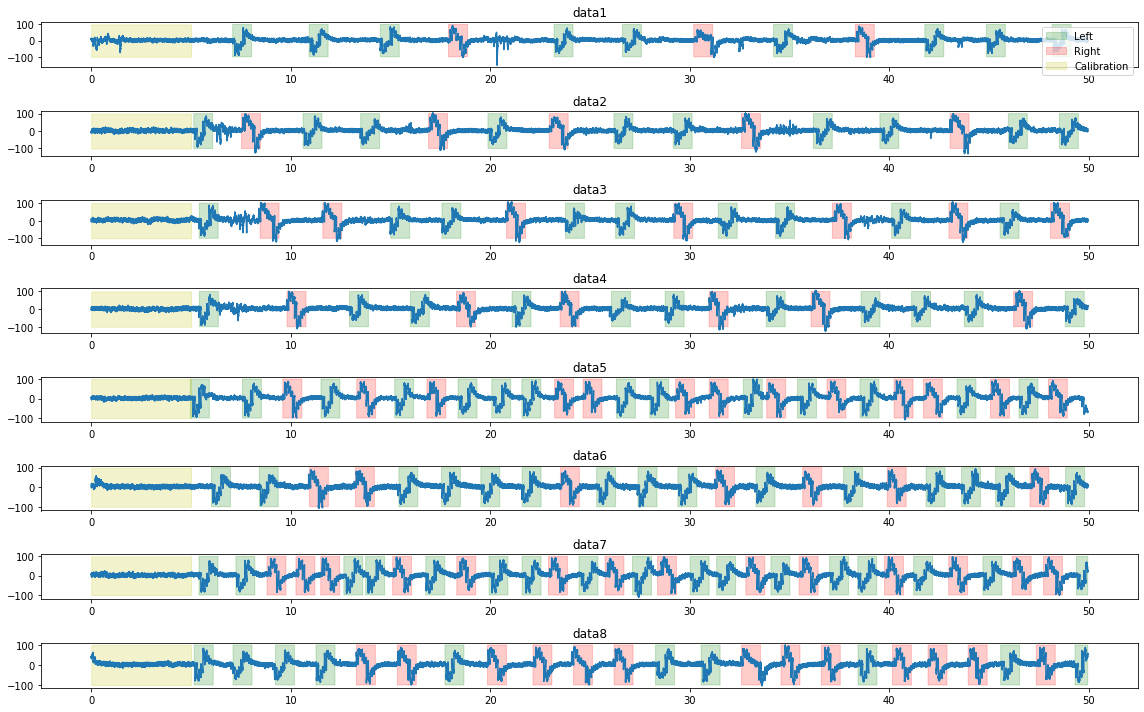

In [4]:
def plot_labelled_wave(wav_array, samprate, labels_dat, ax, i, title="", calibration_seconds = 5, 
                       before_buffer = 1, after_buffer = 1, shade_alpha=0.2, wave_alpha=1, 
                       ymin = -512, ymax = 512):
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate
    
    # Calibration period
    calibration_bool = time_seq < calibration_seconds

    # Get locations of events
    left_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "L"]:
        left_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | left_events_bool
    right_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "R"]:
        right_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | right_events_bool

    # Plot wave with events
    ax[i].plot(time_seq, wav_array, alpha=wave_alpha)
    ax[i].fill_between(time_seq, ymax, ymin,
                     where = left_events_bool,
                     color = 'g',
                     label = "Left",
                     alpha=shade_alpha)
    ax[i].fill_between(time_seq, ymax, ymin,
                     where = right_events_bool,
                     color = 'r',
                     label = "Right",
                     alpha=shade_alpha)
    ax[i].fill_between(time_seq, ymax, ymin,
                     where = calibration_bool,
                     color = 'y',
                     label = "Calibration",
                     alpha=shade_alpha)
    ax[i].set_title(title)
    

fig, ax = plt.subplots(8, 1)
fig.set_size_inches(16, 10)
for i, key in enumerate(sorted(waves.keys())):
    plot_labelled_wave(
        waves[key], samprate, labels[key], ax, i, title=key, before_buffer = time_buffers_whole[key][0],
        after_buffer = time_buffers_whole[key][1], shade_alpha=0.2, wave_alpha=1, ymin = -100, ymax = 100
    )
for i, key in enumerate(sorted(test_waves.keys())):
    plot_labelled_wave(
        test_waves[key], samprate, test_labels[key], ax, i+6, title=key, before_buffer = time_buffers_whole[key][0],
        after_buffer = time_buffers_whole[key][1], shade_alpha=0.2, wave_alpha=1, ymin = -100, ymax = 100
    )
ax[0].legend()
fig.tight_layout()


### Basic Streaming Algorithm Structure

First, we must define the basic structure of our streaming classifier. In order to run experiments, the we need a function that will simulate livestreaming the static dataset.

In [5]:
# Function that reads in the kth <inputBufferSize> sized segment of the array
def read_arduinbro(wav_array, inputBufferSize, k):
    if inputBufferSize*(k+1) < len(wav_array):
        data = wav_array[(inputBufferSize*(k)):(inputBufferSize*(k+1))]
    else:
        data = wav_array[(inputBufferSize*(k))::]
    return np.flip(data)


In [6]:
def streaming_classifier(
        wav_array, # Either the array from file (or ser if live = True)
        samprate,
        classifier,
        input_buffer_size_sec = 0.1, # Buffer size in seconds
        store_events = False, # Whether to return the classification window array for debugging purposes
        store_times = False,        # Store time taken for each classification
        live = False,
        FIFO_filename = None,
        create_FIFO_msg = None,

        classifier_params = {},
        classification_window_size_sec = 1.5, # Total detection window [s]

        calibration_window_size_sec = 5, # The length of the calibration period to define the threshold
        calibration_statistic_function = lambda x: np.max(x) - np.min(x), # Function that calculates the calibration statistic

        detection_window_size_sec = 0.5,
        detection_window_offset_sec = 0.5,
        event_test_statistic_function = lambda x: np.max(x) - np.min(x), # Function that calculates the test statistic
        event_threshold_factor = 0.5, # The scale factor of the calibration stat that will become the threshold
        flip_threshold = False, # Threshold is a lower bound if true, upper bound if false
        consecutive_event_triggers = 3, # How many threshold triggers need to occur in a row for an event to be called
        consecutive_nonevent_reset = 1 # How many threshold failures need to occur in a row for the classifier to be primed for a new event
        ):

    # Connect to fifo
    if FIFO_filename is not None:
        fifo = os.open(FIFO_filename, os.O_WRONLY)
    
    if store_events:
        predictions_storage = []
    if store_times:
        classification_times = []
    predictions = ""
    predictions_timestamps = []

    # Initialise variables
    N_loops_over_window = classification_window_size_sec//input_buffer_size_sec
    input_buffer_size = int(round(input_buffer_size_sec * samprate)) # Convert to index
    detection_window_offset = int(round(detection_window_offset_sec * samprate))
    detection_window_size = int(round(detection_window_size_sec * samprate))
    
    # Initialise Calibration
    calibrate = True
    N_loops_calibration = calibration_window_size_sec//input_buffer_size_sec

    # Initialise Event History
    num_event_history = max(consecutive_event_triggers, consecutive_nonevent_reset) + 1 # How many prior events need to be stored
    event_history = np.array([False]*num_event_history)

    # Determine length of stream
    if live:
        N_loops = np.inf
    else:
        total_time = len(wav_array)/samprate
        N_loops = (total_time*samprate)//input_buffer_size

    # Prime the classifier for new event
    primed = True
    
    ### Start stream ###
    k = 0
    while k < N_loops:
        if live:
            data = read_arduino(wav_array,input_buffer_size)
            data_temp = process_data(data)
        else:
            data_temp = read_arduinbro(wav_array, input_buffer_size, k)
        if k < N_loops_over_window:
            if k == 0:
                data_cal = data_temp
                data_window = data_temp
            else:
                data_window = np.append(data_temp, data_window)
                if calibrate:
                    data_cal = np.append(data_temp, data_cal)
            k+=1
            continue
        else:
            data_window = np.roll(data_window,len(data_temp))
            data_window[0:len(data_temp)] = data_temp
            if calibrate:
                data_cal = np.append(data_temp,data_cal)
                if (k > N_loops_calibration):
                    cal_stat = calibration_statistic_function(data_cal)
                    event_threshold = cal_stat*event_threshold_factor
                    calibrate = False
                k+=1
                continue
        # Event Detection
        # Take detection window from classification window
        
        interval = data_window[detection_window_offset:(detection_window_offset + detection_window_size)] 
        test_stat = event_test_statistic_function(interval) # Calculate test stat 
                
        # Test threshold
        if flip_threshold:
            is_event = (test_stat < event_threshold) 
        else:
            is_event = (test_stat > event_threshold)
        
        # Record History
        event_history[1::] = event_history[0:-1]
        event_history[0] = is_event
        
        # if event, pass window to classifier
        if np.all(event_history[0:consecutive_event_triggers]) and primed:
            start = time.time_ns()
            prediction = classifier(data_window, samprate, **classifier_params)
            end = time.time_ns()
            if store_times:
                classification_times.append(end - start)
            if store_events:
                predictions_storage.append(data_window)
                        
            # Record prediction and time interval of event
            predictions += prediction
            end_time = round(k*input_buffer_size_sec, 2)
            start_time = round(end_time - classification_window_size_sec, 2)
            predictions_timestamps.append((start_time, end_time))

            # Pipe it up
            if FIFO_filename is not None:
                msg = create_FIFO_msg(prediction)
                os.write(fifo, msg)
            
            # Unprime
            primed = False
        
        # Check if condition for priming has been met
        if np.all(~event_history[0:consecutive_nonevent_reset]):
            primed = True

        k += 1
    
    if FIFO_filename is not None:
        os.close(fifo)
    
    if store_events and store_times:
        return predictions, predictions_timestamps, predictions_storage, classification_times
    elif store_events:
        return predictions, predictions_timestamps, predictions_storage
    elif store_times:
        return predictions, predictions_timestamps, classification_times
    else:
        return predictions, predictions_timestamps
                  

## Event Detection

### Test Statistic

#### Candidates

In [7]:
# Define Test Stat Functions
def ts_range(x): 
    return np.max(x) - np.min(x)
def ts_IQR(x): 
    return np.quantile(x, 0.75) - np.quantile(x, 0.25)
def ts_abs_max(x): 
    return np.max(np.abs(x))
def ts_zero_crossings(x):
    return np.sum(x[0:-1]*x[1::] <= 0)
def max_frequency(frame, samprate=10000):
    fs = samprate
    dt = 1/fs
    t = np.arange(0, (len(frame)*dt), dt)

    # Num samples
    N = len(frame)

    yf = fft(frame)
    xf = fftfreq(N, 1/fs)
    np.size(xf)
    np.size(t)

    f, t, Sxx = signal.spectrogram(frame, fs)
    maximum = np.max(Sxx)
    threshold = maximum/5;
    maximum_Freqs = np.amax(Sxx, 0) # max frequency for each time

    return np.amax(maximum_Freqs)

tfn_candidates = {"Range": ts_range,
                  "IQR": ts_IQR,
                  "SD": np.std,
                  "Absolute Max": ts_abs_max,
                  "Zero Crossings": ts_zero_crossings,
                  "Fourier": max_frequency}



#### Evaluation Metric: Contrast

In [8]:
def contrast(events, non_events): 
    pooled_sd = np.sqrt(np.var(events)/len(events) + np.var(non_events)/len(non_events))
    return (np.mean(events, axis=1) - np.mean(non_events, axis=1))/pooled_sd

In [9]:
def get_event_regions(wav_array, samprate, labels_dat, time_buffer):
    before_buffer = time_buffer[0]
    after_buffer = time_buffer[1]
    
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

    left_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "L"]:
        left_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | left_events_bool

    right_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "R"]:
        right_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | right_events_bool

    event_bool = left_events_bool | right_events_bool
    return event_bool


def get_test_stats(wav_array, window_size, step, test_stat_fns):
    test_stats = np.zeros((len(test_stat_fns), len(wav_array)))
    all_windows = np.lib.stride_tricks.sliding_window_view(wav_array, window_shape = window_size)
    all_windows = all_windows[::step, :]
    for i, fn in enumerate(test_stat_fns):
        testicles = np.apply_along_axis(fn, -1, all_windows)
        for j, teste in enumerate(testicles):
            if j == len(testicles)-1:
                test_stats[i, (j*step)::] = teste
            else:
                test_stats[i, (j*step):((j+1)*step)]  = teste
    return test_stats


def get_contrast(wav_array, samprate, labels_dat, window_size, step, test_stat_fns, contrast_fn, time_buffer):
    test_stats = get_test_stats(wav_array, window_size, step, test_stat_fns)
    events_bool = get_event_regions(wav_array, samprate, labels_dat, time_buffer)
    event_test_stats = test_stats[:, events_bool]           
    non_event_test_stats = test_stats[:, ~events_bool]
    contrast_stat = contrast_fn(event_test_stats, non_event_test_stats)
    return contrast_stat

    
def contrast_all_files(output_filename, window_size, test_stat_fns, samprate, 
                       waves, labels, contrast_fn, step=0.1, time_buffers=time_buffers_whole):   
    step = int(step*samprate)
    for i, key in enumerate(waves.keys()):
        wav_array = waves[key]
        labels_dat = labels[key]
        
        cont = get_contrast(wav_array, samprate, labels_dat,
                         window_size, step, test_stat_fns,
                         contrast_fn, time_buffers[key])
        with open(output_filename, "a") as file:
            file.write(",".join([str(window_size), key]) + "," + ','.join(np.round(cont, 4).astype(str)) + "\n")


In [10]:
output_filename_event_det_opt = PATH + "event_detection_optimisation.csv"

open(output_filename, 'w').close()    # Clears the file so that the code can be run again.
for x in np.linspace(100, 20000, 200):
    x = int(x)
    if x%2000 == 0:
        print(x)
    contrast_all_files(
        output_filename_event_det_opt, 
        window_size = x, 
        test_stat_fns = tfn_candidates.values(),
        samprate = samprate,
        waves = waves,
        labels = labels,
        step = 0.1,
        contrast_fn = contrast,
        time_buffers = time_buffers_whole
    )

/Users/billydodds/.pyenv/versions/3.8.3/envs/phys/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/billydodds/.pyenv/versions/3.8.3/envs/phys/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


2000
4000
6000
8000
10000
12000
14000
16000
18000
20000


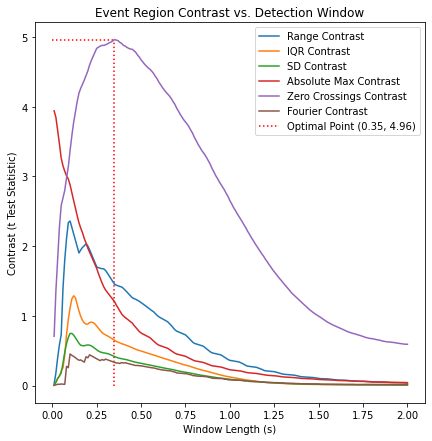

In [12]:
contrasts = pd.read_csv(output_filename_event_det_opt, header=None)
contrasts.columns = ["window_size", "file"] + list(tfn_candidates.keys())
contrasts_total = contrasts.groupby("window_size").mean()

plt.figure(figsize=(7, 7))
for stat in tfn_candidates.keys():
    plt.plot(contrasts_total.index/samprate,
             np.abs(contrasts_total[stat]),
             label = f"{stat} Contrast", alpha = 1)

plt.title("Event Region Contrast vs. Detection Window")
plt.xlabel("Window Length (s)")    
plt.ylabel("Contrast (t Test Statistic)")  
opt_det_window = contrasts_total.index[np.argmax(np.abs(contrasts_total["Zero Crossings"]))]/samprate
opt_det_window_val = np.max(np.abs(contrasts_total["Zero Crossings"]))
plt.vlines(opt_det_window, 0, opt_det_window_val,"r", ":", 
           label=f"Optimal Point ({round(opt_det_window, 2)}, {round(opt_det_window_val, 2)})")
plt.hlines(opt_det_window_val, 0, opt_det_window,"r", ":")
plt.legend()
plt.savefig(PATH+"contrast.png")

### Threshold

In [15]:
calibration_window_sec = 5

st_list = []
f_score_list = []
for st_scale in np.linspace(0.01, 1, 100):
    fps, fns, tps, i = 0, 0, 0, 0
    for key in waves.keys():
        predictions, predictions_timestamps = streaming_classifier(
            waves[key],
            samprate,
            lambda x,y: "R" if np.random.rand()<0.5 else "L",
            input_buffer_size_sec = 0.05,
            classification_window_size_sec = opt_det_window,
            detection_window_size_sec = opt_det_window,
            detection_window_offset_sec = 0,
            calibration_window_size_sec = 5,
            calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
            event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
            event_threshold_factor = st_scale, # The scale factor of the calibration stat that will become the threshold
            flip_threshold = True, # Threshold is a lower bound, so true
            consecutive_event_triggers = 3, # How many threshold triggers need to occur in a row for an event to be called
            consecutive_nonevent_reset = 10 # How many threshold failures need to occur in a row for the classifier to be primed for a new event
        )
        before_buffer = time_buffers_hump[key][0]
        after_buffer = time_buffers_hump[key][1]
        actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
        actual_leftovers = deepcopy(actual_times)
        pred_leftovers = deepcopy(predictions_timestamps)
        tps += len(actual_times)
        for act_times in actual_times:
            if act_times[1] < calibration_window_sec:
                actual_leftovers.remove(act_times)
                continue
            for pred_times in predictions_timestamps:
                if act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and pred_times in pred_leftovers and act_times in actual_leftovers:
                    actual_leftovers.remove(act_times)
                    pred_leftovers.remove(pred_times)
        tps -= len(actual_leftovers)
        fns += len(actual_leftovers)
        fps += len(pred_leftovers)
        i += 1
    fscore = tps/(tps+0.5*(fns+fps))
    if (st_scale*100)%10 == 0:
        print(st_scale, fscore)
    st_list.append(st_scale)
    f_score_list.append(fscore)


0.09999999999999999 0.7777777777777778
0.2 0.963302752293578
0.3 0.9771689497716894
0.4 0.9497716894977168
0.5 0.9321266968325792
0.6 0.9259259259259259
0.7000000000000001 0.897196261682243
0.8 0.8380952380952381
0.9 0.7281553398058253
1.0 0.5


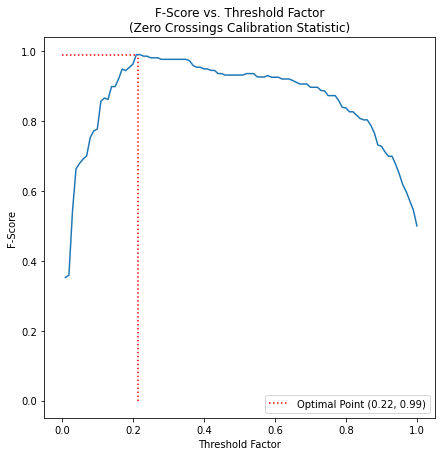

In [16]:
plt.figure(figsize=(7, 7))
plt.plot(st_list, f_score_list)
plt.title("F-Score vs. Threshold Factor\n(Zero Crossings Calibration Statistic)")
st_list = np.array(st_list)
opt_thresh = np.mean(st_list[f_score_list == np.max(f_score_list)])
opt_fscore = np.max(f_score_list)
plt.vlines(opt_thresh, 0, opt_fscore, "r", ":", 
           label=f"Optimal Point ({round(opt_thresh, 2)}, {round(opt_fscore, 2)})")
plt.hlines(opt_fscore, 0, opt_thresh, "r", ":")
plt.xlabel("Threshold Factor")
plt.ylabel("F-Score")
plt.legend(loc = "lower right")
plt.savefig(PATH+"threshold.png")

## Classification

### Classifier Candidates

In [17]:
# Prepare Classifier Candidates

# catch22 kNN classifier (using stepwise selected features)
step_csv = PATH+"catch22_step_selected_features.csv"
catch22_step_training_data = pd.read_csv(path+step_csv)
X_train = catch22_step_training_data.iloc[:,0:-1]
y_labels = catch22_step_training_data.iloc[:,-1]   
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_labels)

# "Zeros" classifier
# returns a list of sub-arrays, grouped by the same consecutive value
# (in this case they are groups of consecutive 1s or -1s) 

@njit # numba decorator that performs just-in-time (jit) compilation
def consecutive(data, stepsize=0):                              
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

@njit 
def zeroes_classifier(arr, samprate, downsample_rate=10, ave_height = 10, consec_seconds = 0.2):
    arr_ds = arr[0::downsample_rate]
    arr_sign = np.sign(arr_ds)            #returns array of -1s and 1s, depending on if the number was negative or positive respectively
    i = 0
    split_arrays = consecutive(arr_sign)  #returns a list of sub-arrays, grouped by the same consecutive value (in this case they are groups of consecutive 1s or -1s)
    for sub_arr in split_arrays:
        if len(sub_arr) > consec_seconds * samprate / downsample_rate:          #RHS converts seconds to number of samples
            # #if there were 'consec_seconds' seconds of no zero-crossings, then check if the average height is bigger than 'ave_height'
            if np.mean(arr_ds[i:(i + len(sub_arr) - 1)]) > ave_height:          
                return 'R'
            elif np.mean(arr_ds[i:(i + len(sub_arr) - 1)]) < -1 * ave_height:
                return 'L'
        i += len(sub_arr)
    return '_'                            #unable to classify because there were not 'consec_seconds' seconds of no zero-crossings


def catch22_knn_classifier(arr, samprate, downsample_rate=10):
    arr_ds = arr[0::downsample_rate]
    arr_list = arr_ds.tolist()
    feature_one = catch22.DN_HistogramMode_5(arr_list)
    feature_two = catch22.SB_BinaryStats_mean_longstretch1(arr_list)
    feature_three = catch22.FC_LocalSimple_mean1_tauresrat(arr_list)
    feature_four = catch22.DN_OutlierInclude_p_001_mdrmd(arr_list)
    feature_five = catch22.SP_Summaries_welch_rect_area_5_1(arr_list)
    test_features = [[feature_one, feature_two, feature_three, feature_four, feature_five]]
    return neigh.predict(test_features)[0]                    


def one_pronged_smoothing_classifier(arr, samprate, downsample_rate=10, window_size_seconds=0.3, max_loops=10):
    arr_ds = arr[0::downsample_rate]
    fs = samprate/downsample_rate
    dt = 1/fs
    t = np.arange(0, (len(arr_ds)*dt), dt)

    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)

    # Indices of positive maxima
    max_locs = np.array(signal.argrelextrema(filtered_arr, np.greater)[0])
    max_vals = filtered_arr[max_locs]
    max_locs = max_locs[max_vals > 0]
    
    # Indices of negative minima
    min_locs = np.array(signal.argrelextrema(filtered_arr, np.less)[0])
    min_vals = filtered_arr[min_locs]
    min_locs = min_locs[min_vals < 0]
    
    max_min_locs = np.append(max_locs, min_locs)    # Appended indices
    max_min_values = filtered_arr[max_min_locs]     # Values of above indices    
    abs_max_min_values = np.abs(max_min_values)     # Absolute value of those values

    # A vector with a length equal to the number of minimums: all '-1' to say minimum
    numMin = [-1]*len(min_locs)    
    numMax = [1]*len(max_locs)     # Same for max, but with '1'
    isMin = np.append(numMax, numMin)
    val_and_idx = np.vstack([abs_max_min_values, max_min_locs, isMin])
    # Sort the magnitudes of the extrema in descending order (-1 indicates descending)
    val_and_idx_sorted = val_and_idx[ :, (-1*val_and_idx[0]).argsort()]

    if val_and_idx_sorted.shape == (3, 0):
        if val_and_idx_sorted[2] == -1:
            return 'L'
        elif val_and_idx_sorted[2] == 1:
            return 'R'
        else:
            return "_"
    else:
        if val_and_idx_sorted[2, 0] == -1:
            return 'L'
        elif val_and_idx_sorted[2, 0] == 1:
            return 'R'
        else:
            return "_"


def two_pronged_smoothing_classifier(arr, samprate, downsample_rate=10, 
                                       window_size_seconds=0.3, max_loops=10):
    arr_ds = arr[0::downsample_rate]
    fs = samprate/downsample_rate
    dt = 1/fs
    t = np.arange(0, (len(arr_ds)*dt), dt)

    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)

    # Indices of positive maxima
    max_locs = np.array(signal.argrelextrema(filtered_arr, np.greater)[0])
    max_vals = filtered_arr[max_locs]
    max_locs = max_locs[max_vals > 0]
    
    # Indices of negative minima
    min_locs = np.array(signal.argrelextrema(filtered_arr, np.less)[0])
    min_vals = filtered_arr[min_locs]
    min_locs = min_locs[min_vals < 0]
    
    max_min_locs = np.append(max_locs, min_locs)    # Appended indices
    max_min_values = filtered_arr[max_min_locs]     # Values of above indices    
    abs_max_min_values = np.abs(max_min_values)     # Absolute value of those values

    # A vector with a length equal to the number of minimums: all '-1' to say minimum
    numMin = [-1]*len(min_locs)    
    numMax = [1]*len(max_locs)     # Same for max, but with '1'
    isMin = np.append(numMax, numMin)
    val_and_idx = np.vstack([abs_max_min_values, max_min_locs, isMin])
    # Sort the magnitudes of the extrema in descending order (-1 indicates descending)
    val_and_idx_sorted = val_and_idx[ :, (-1*val_and_idx[0]).argsort()]
    
    # We will continue looping until we have an appropriate classification. 
    # This relies on having the extrema INTERCHANGE between max and min (no two min right next to eachother)
    loops = 0
    classificationFound = False
    while not classificationFound and loops < max_loops:
        
        top_2 = val_and_idx_sorted[:, 0:2]             # Take the top two magnitudes
        top_2_sorted = top_2[ :, top_2[1].argsort()]   # Sort according to the indices of those values
        if top_2_sorted.shape != (3, 2):               # Break if we run out of turning points
            return "_"
        
        # If two min or two max occur one after the other, 
        # we know we have an inappropriate result so we delete one of those doubled min/max
        if top_2_sorted[2, 0]*top_2_sorted[2, 1] > 0:
            val_and_idx_sorted = np.delete(val_and_idx_sorted, 1, 1)
        else:
            classificationFound = True
        loops += 1
    if top_2_sorted[2, 0] == -1:
        return 'L'
    elif top_2_sorted[2, 0] == 1:
        return 'R'
    else:
        return "_"


def max_min_classifier(arr, samprate, downsample_rate=10):
    arr_ds = arr[0::downsample_rate]
    arr_max = np.amax(arr_ds)
    arr_min = np.amin(arr_ds)
    max_loc = np.where(arr_ds == arr_max)[0][0]
    min_loc = np.where(arr_ds == arr_min)[0][0]
    if max_loc > min_loc:
        return "R"
    elif min_loc > max_loc:
        return "L"
    else:
        print("Flat wave!!!!")
        return "_"


In [18]:
# Prepare classifiers for optimisation and plotting
classifiers = {"One-pronged": one_pronged_smoothing_classifier,
               "Two-pronged": two_pronged_smoothing_classifier,
               "Max-Min": max_min_classifier,
               "Zeros": zeroes_classifier,
               "KNN": catch22_knn_classifier,
               "Naive Random": lambda x,y: "R" if np.random.rand()<0.5 else "L",
               "Naive Undecided": lambda x,y: "_"}

classifier_parameters = {"One-pronged": {},
               "Two-pronged": {},
               "Max-Min": {},
               "Zeros": {"consec_seconds": 0.2, "ave_height": 0.25},
               "KNN": {},
               "Naive Random": {},
               "Naive Undecided": {}}

classifier_colours = {"One-pronged": "tab:blue",
               "Two-pronged": "tab:cyan",
               "Max-Min": "tab:olive",
               "Zeros": "tab:purple",
               "KNN": "tab:pink",
               "Naive Random": "tab:red",
               "Naive Undecided": "tab:orange"}


### Accuracy Metric

In [19]:
def my_lev_dist(prediction, actual, L_cost = 1.25, R_cost = 1.25, under_score_cost = 0.5):
    substitute_costs = np.ones((128, 128), dtype=np.float64)  
    substitute_costs[ord('L'), ord('R')] = L_cost
    substitute_costs[ord('R'), ord('L')] = R_cost
    substitute_costs[ord('_'), ord('L')] = under_score_cost
    substitute_costs[ord('_'), ord('R')] = under_score_cost
    return lev(prediction, actual, substitute_costs = substitute_costs)


### Classifier Optimisation

In [20]:
output_filename_cls_opt = PATH + "classifier_optimisation.csv"
open(output_filename, 'w').close()    # Clear the file

search_space = (2-opt_det_window)/2
granularity = 200

for classifier_label, classifier in classifiers.items():
    print(classifier_label)
    for i, w in enumerate(np.linspace(0, search_space, granularity)):
        w = max(1e-5, w)
        if i%(granularity//10) == 0:
            print(f"{i} of {granularity}")
        classification_window = opt_det_window+2*w
        buffer_size = 0.05
        for i, key in enumerate(waves):
            predictions, predictions_timestamps = streaming_classifier(
                waves[key],
                samprate,
                classifier,
                classifier_params=classifier_parameters[classifier_label],
                input_buffer_size_sec = buffer_size,
                classification_window_size_sec = classification_window,
                detection_window_size_sec = opt_det_window,
                detection_window_offset_sec = w,
                calibration_window_size_sec = 5,
                calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                event_threshold_factor = opt_thresh, # The scale factor of the calibration stat that will become the threshold
                flip_threshold = True, # Threshold is a lower bound, so true
                consecutive_event_triggers = 3, # How many threshold triggers need to occur in a row for an event to be called
                consecutive_nonevent_reset = 10 # How many threshold failures need to occur in a row for the classifier to be primed for a new event
            )
            actuals = "".join(labels[key].label)
            lev_dist = my_lev_dist(predictions, actuals)
            acc = max((len(actuals) - lev_dist), 0)/len(actuals)
            with open(output_filename, "a") as file:
                file.write(",".join([classifier_label, str(classification_window), key, predictions, actuals, str(lev_dist), str(acc)]) + '\n')


One-pronged
0 of 200


<ipython-input-17-23fb8fa48549>:82: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if val_and_idx_sorted[2] == -1:
<ipython-input-17-23fb8fa48549>:84: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif val_and_idx_sorted[2] == 1:


20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200
Two-pronged
0 of 200
20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200
Max-Min
0 of 200
20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200
Zeros
0 of 200
20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200
KNN
0 of 200
20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200
Naive Random
0 of 200
20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200
Naive Undecided
0 of 200
20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200


In [21]:
results = pd.read_csv(output_filename_cls_opt, header=None)
results.columns = ["classifier", "window_size", "file", "predicted", "actual", "lev_dist", "accuracy"]
results_agg = results.groupby(["window_size", "classifier"]).mean()
results_agg.reset_index(inplace=True)
results_agg

window_size       classifier  lev_dist  accuracy
0         0.35002              KNN  8.666667  0.531224
1         0.35002          Max-Min  4.791667  0.717558
2         0.35002     Naive Random  7.083333  0.596836
3         0.35002  Naive Undecided  9.416667  0.476307
4         0.35002      One-pronged  4.875000  0.721173
...           ...              ...       ...       ...
1395      2.00000     Naive Random  7.666667  0.542227
1396      2.00000  Naive Undecided  9.416667  0.477421
1397      2.00000      One-pronged  2.916667  0.823343
1398      2.00000      Two-pronged  7.833333  0.539833
1399      2.00000            Zeros  7.833333  0.539833

[1400 rows x 4 columns]

0.6402010050251256 0.4835330428467684


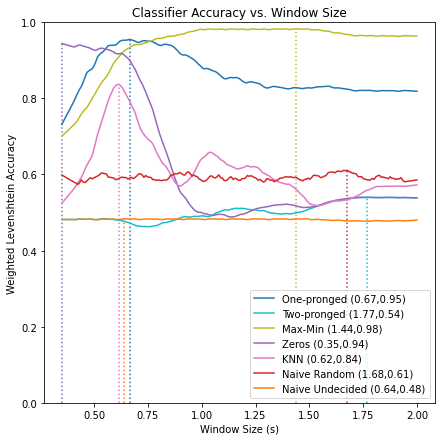

In [22]:
optimal_cl_windows = {}

plt.figure(figsize=(7, 7))
for classifier in results.classifier.unique():
    filt = results_agg.classifier == classifier
    max_arg = np.argmax(signal.savgol_filter(results_agg[filt].accuracy, 15, 1))
    max_val = np.max(signal.savgol_filter(results_agg[filt].accuracy, 15, 1))
    optimal_cl_window = np.array(results_agg[filt].window_size)[max_arg]
    optimal_cl_windows[classifier] = optimal_cl_window
    
    plt.plot(results_agg[filt].window_size, signal.savgol_filter(results_agg[filt].accuracy, 15, 1),
             label=classifier + f" ({round(optimal_cl_window, 2)},{round(max_val, 2)})", color=classifier_colours[classifier])
    plt.vlines(optimal_cl_window, 0, max_val, color=classifier_colours[classifier], linestyle=":")
    
plt.ylabel("Weighted Levenshtein Accuracy")
plt.xlabel("Window Size (s)")
plt.title("Classifier Accuracy vs. Window Size")
plt.ylim(0, 1)

plt.legend(loc="lower right")
print(optimal_cl_window, max_val)
plt.savefig(PATH+"classifier.png")

## Evaluation

In [28]:
output_filename_tst_res = PATH + "test_results.csv"
open(output_filename, 'w').close()    # Clear the file

for classifier_label, classifier in classifiers.items():
    print(classifier_label)
    offset = (optimal_cl_windows[classifier_label] - opt_det_window)/2
    buffer_size = 0.05
    for i, key in enumerate(test_waves):
        predictions, predictions_timestamps = streaming_classifier(
            test_waves[key],
            samprate,
            classifier,
            classifier_params=classifier_parameters[classifier_label],
            input_buffer_size_sec = buffer_size,
            classification_window_size_sec = optimal_cl_windows[classifier_label],
            detection_window_size_sec = opt_det_window,
            detection_window_offset_sec = offset,
            calibration_window_size_sec = 5,
            calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
            event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
            event_threshold_factor = opt_thresh, # The scale factor of the calibration stat that will become the threshold
            flip_threshold = True, # Threshold is a lower bound, so true
            consecutive_event_triggers = 3, # How many threshold triggers need to occur in a row for an event to be called
            consecutive_nonevent_reset = 10 # How many threshold failures need to occur in a row for the classifier to be primed for a new event
        )
        actuals = "".join(test_labels[key].label)
        lev_dist = my_lev_dist(predictions, actuals)
        acc = max((len(actuals) - lev_dist), 0)/len(actuals)
        with open(output_filename, "a") as file:
            file.write(",".join([classifier_label, key, predictions, actuals, str(lev_dist), str(acc)]) + '\n')


One-pronged
Two-pronged
Max-Min
Zeros
KNN
Naive Random
Naive Undecided


In [29]:
test_results = pd.read_csv(output_filename_tst_res, header=None)
test_results.columns = ["Classifier", "File", "Predicted", "Actual", "Weighted Levenshtein Distance", "Accuracy"]

test_results = test_results.pivot(index = "File", columns='Classifier', values='Accuracy')
test_results.loc['Total']= test_results.mean()
test_results

Classifier       KNN   Max-Min  Naive Random  Naive Undecided  One-pronged  \
File                                                                         
data7       0.750000  0.870968      0.709677         0.435484     0.870968   
data8       0.586957  0.913043      0.739130         0.500000     0.858696   
Total       0.668478  0.892006      0.724404         0.467742     0.864832   

Classifier  Two-pronged     Zeros  
File                               
data7          0.669355  0.854839  
data8          0.456522  0.771739  
Total          0.562938  0.813289

## Space Invaders!

In [30]:
def encode_msg_size(size: int) -> bytes:
    return struct.pack("<I", size)

def decode_msg_size(size_bytes: bytes) -> int:
    return struct.unpack("<I", size_bytes)[0]

def create_msg(content: bytes) -> bytes:
    size = len(content)
    return encode_msg_size(size) + content


In [32]:
# # Final classifier used for Space Invaders
# baudrate = 230400
# cport = "/dev/cu.usbserial-DJ00E33Q"
# ser = serial.Serial(port=cport, baudrate=baudrate)    
# inputBufferSize = 1000   # 20000 = 1 second
# buffer_size_sec = inputBufferSize/20000.0
# ser.timeout = buffer_size_sec  # set read timeout 20000

# classifier_label = "One-pronged"

# print(classifier_label)
# offset = (optimal_cl_windows[classifier_label] - opt_det_window)/2
# buffer_size = 0.05
# streaming_classifier(
#     ser,
#     samprate,
#     classifiers[classifier_label],
#     classifier_params=classifier_parameters[classifier_label],
#     input_buffer_size_sec = buffer_size_sec,
#     classification_window_size_sec = optimal_cl_windows[classifier_label],
#     detection_window_size_sec = opt_det_window,
#     detection_window_offset_sec = offset,
#     calibration_window_size_sec = 5,
#     calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
#     event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
#     event_threshold_factor = opt_thresh, 
#     flip_threshold = True, 
#     consecutive_event_triggers = 3, 
#     consecutive_nonevent_reset = 10,
#     live = True,
#     FIFO_filename = "space_invaders_ipc",
#     create_FIFO_msg = None,
#     )
